In [1]:
from utils import (create_embeddings,
                   calc_ann_metric, 
                   display_random_item,
                   )
import pandas as pd
import cv2 as cv2
from tqdm.notebook import tqdm
import torch
from models import LitModel
from torchvision import transforms
from annoy import AnnoyIndex

In [2]:
company_data = pd.read_csv("company_data.csv")
comparable_data = pd.read_csv("comparable_data.csv")

In [3]:
company_data.head(3)

,title,price,cat_1,cat_2,cat_3,caracteristics,img_ref,target,dealer
0,Беговая дорожка SOLE F65,169900,Беговые дорожки,Электрические беговые дорожки,SOLE,Тип дорожки:для домашнего использования Скорос...,images/begovye_dorozhki/1_sportdoma_19512.jpeg,begovye_dorozhki,sportdoma
1,Беговая дорожка OXYGEN M-CONCEPT SPORT,109990,Беговые дорожки,Электрические беговые дорожки,OXYGEN,Тип дорожки:электрическая Скорость:1 - 14 км/ч...,images/begovye_dorozhki/2_sportdoma_17451.jpeg,begovye_dorozhki,sportdoma
2,Беговая дорожка OXYGEN FITNESS RUNUP GROOVE A,63990,Беговые дорожки,Электрические беговые дорожки,OXYGEN,"Тип дорожки:домашняя, электрическая Скорость:1...",images/begovye_dorozhki/3_sportdoma_22172.jpeg,begovye_dorozhki,sportdoma


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
default_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [6]:
trained_model = LitModel.load_from_checkpoint(
    "resnet_class_v1.ckpt", num_epochs=5, len_dataset = 13, learning_rate=0.001
)

In [7]:
from torch import nn

class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [8]:
trained_model.fc = Identity()
trained_model.to(device)

LitModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [9]:
company_img_embeddings = create_embeddings(
    "company_data.csv", trained_model, default_transform, device
)
company_emb_flat = [x for xs in company_img_embeddings for x in xs]

  0%|          | 0/984 [00:00<?, ?it/s]

In [10]:
database_img_embeddings = create_embeddings(
    "comparable_data.csv", trained_model, default_transform, device
)

database_emb_flat = [x for xs in database_img_embeddings for x in xs]

  0%|          | 0/13718 [00:00<?, ?it/s]

In [12]:
forest = AnnoyIndex(len(database_emb_flat[0]), metric="angular")
for i, item in tqdm(enumerate(database_emb_flat)):
    forest.add_item(i, item.cpu().detach().tolist())
forest_labels = comparable_data["target"].tolist()
forest.build(50)
forest.save("forest_resnet_train_v1.ann")

0it [00:00, ?it/s]

True

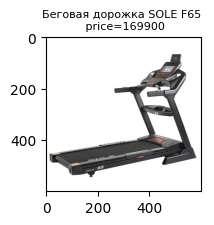

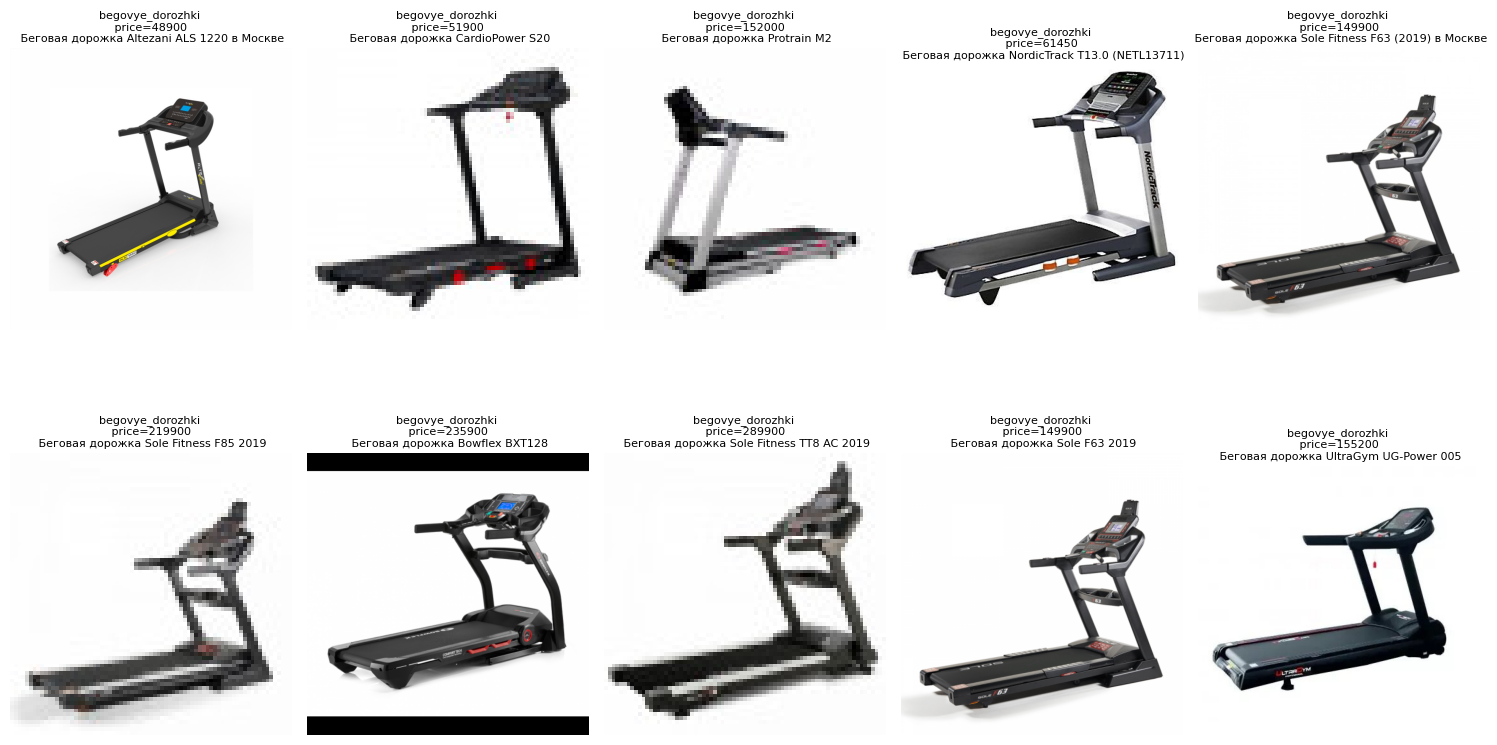

In [13]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=0,
    method="ann",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=None,
    tokenizer=None,
)

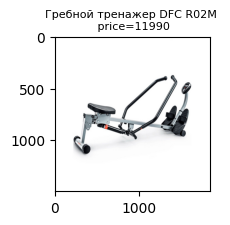

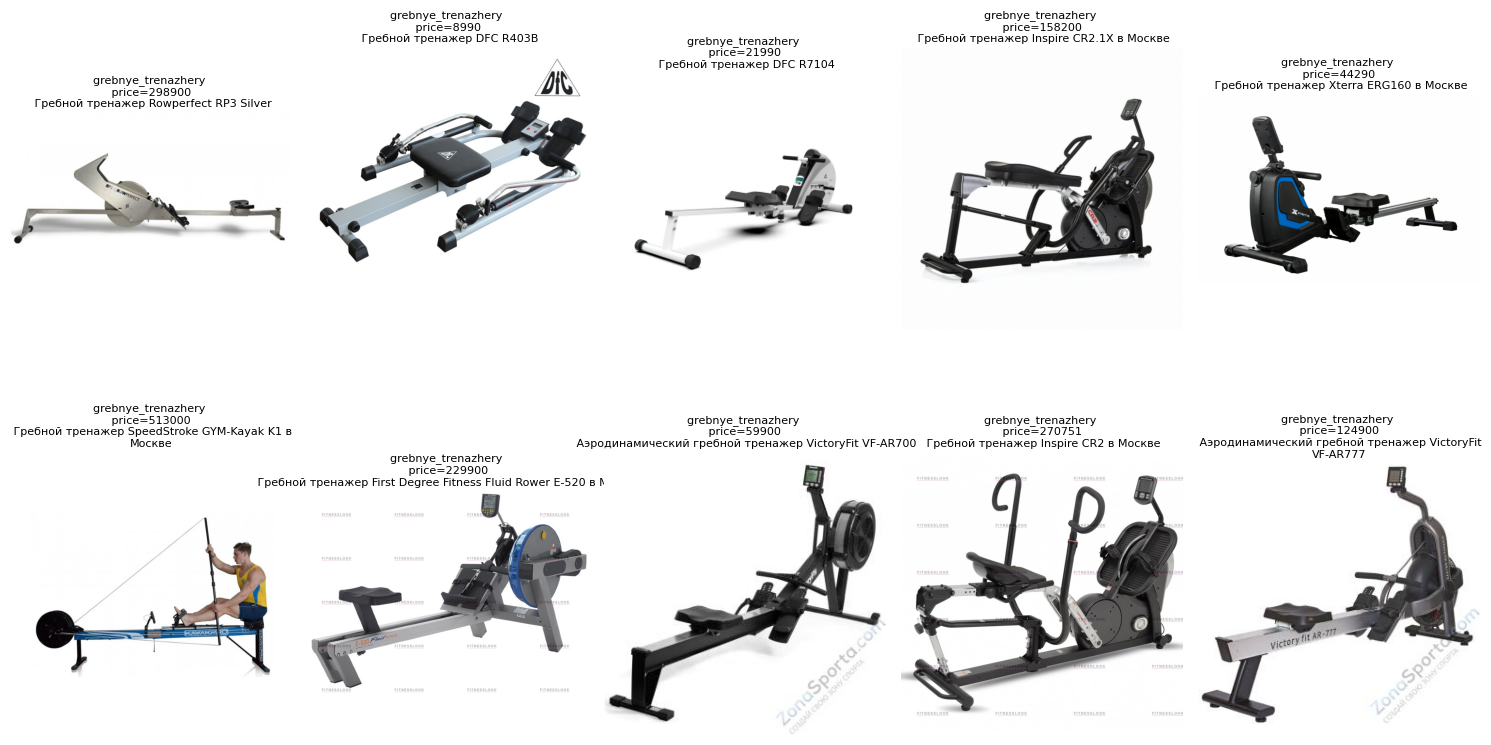

In [14]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=500,
    method="ann",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=None,
    tokenizer=None,
)

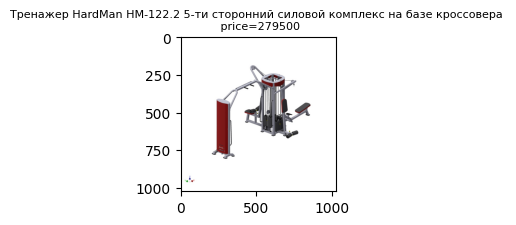

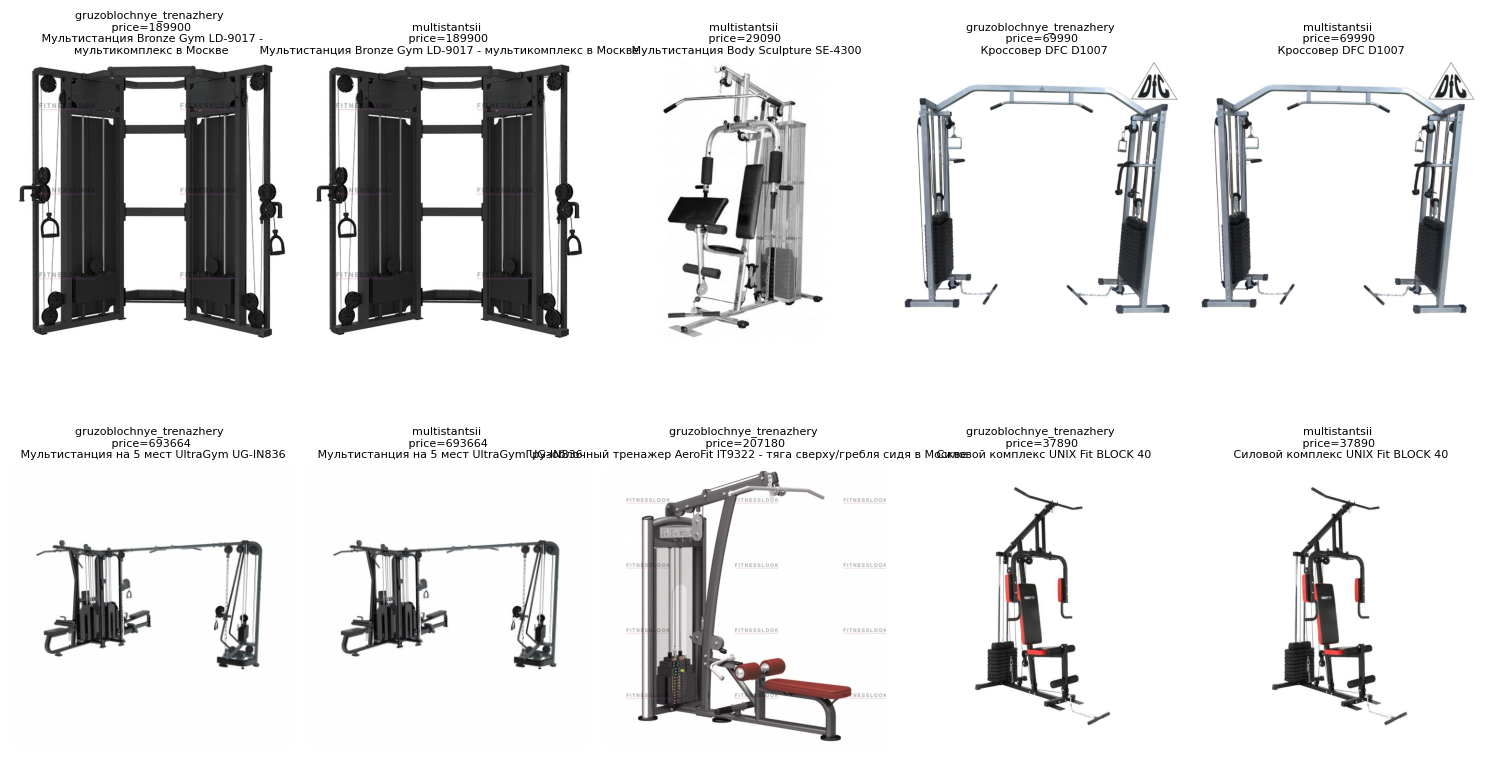

In [15]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=621,
    method="ann",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=None,
    tokenizer=None,
)

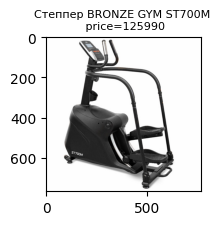

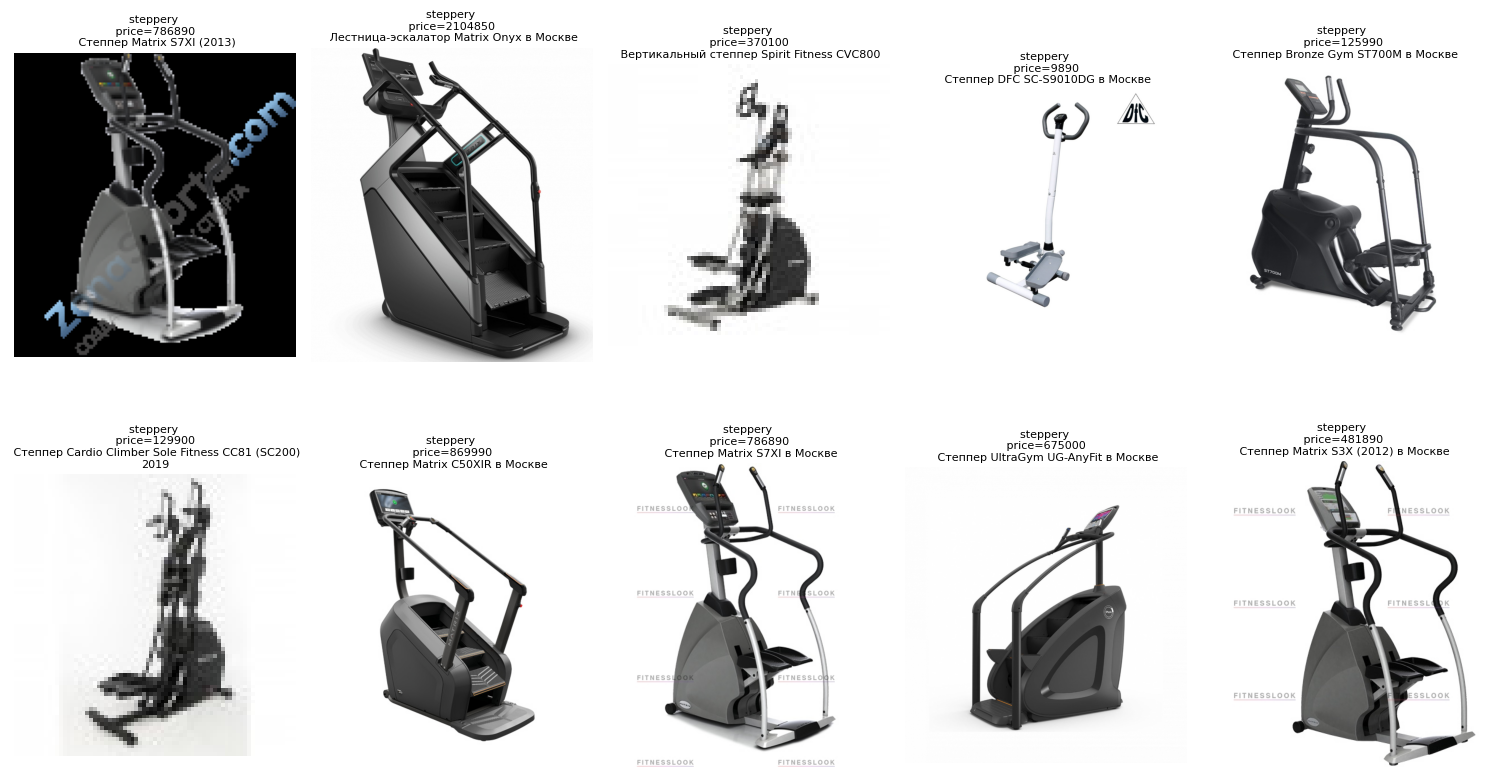

In [16]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=626,
    method="ann",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=None,
    tokenizer=None,
)

In [17]:
calc_ann_metric(10, forest, company_emb_flat, company_data, comparable_data)
calc_ann_metric(5, forest, company_emb_flat, company_data, comparable_data)

  0%|          | 0/984 [00:00<?, ?it/s]

trenazhery_na_svobodnykh_vesakh acc at 10: 0.9776
begovye_dorozhki acc at 10: 0.9995
velotrenazhery acc at 10: 0.9925
steppery acc at 10: 0.52
ellipticheskie_trenazhery acc at 10: 0.9979
multistantsii acc at 10: 0.8233
grebnye_trenazhery acc at 10: 0.99
Total acc at 10: 0.9455


  0%|          | 0/984 [00:00<?, ?it/s]

trenazhery_na_svobodnykh_vesakh acc at 5: 0.9755
begovye_dorozhki acc at 5: 0.9991
velotrenazhery acc at 5: 0.9912
steppery acc at 5: 0.5382
ellipticheskie_trenazhery acc at 5: 0.9979
multistantsii acc at 5: 0.8183
grebnye_trenazhery acc at 5: 0.99
Total acc at 5: 0.9453
